In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from sklearn.datasets import make_blobs
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

---
Kernels
=====
***

---
Kernel methods of density estimation (non-parameteric methods)
=====
***

###We have seen from the Nearest Neighbor notebook that:

###$p(x) = \frac{K}{NV}$

###$K$ is the number of points within the volume $V$ (remember the histogram)
###$N$ is the total number of points

###Nearest neighbors sought to fix a $K$ and determine $V$, you will use the volume that contains $K$ points, where you have specified the $K$

###THE ALTERNATIVE APPROACH, IS

###To fix a volume and allow that volume to determine the $K$. This approach to determining $p(x)$ is known as kernel density estimation

###A common choice for the kernel is the Gaussian Distribution

$$p(x) = \frac{1}{M}\sum_{m=1}^{M}\frac{1}{(2\pi h^{2})^{\frac{D}{2}}} exp \left[ - \frac{||x - x_{m}||^{2}}{2h^{2}}\right]$$

###$h$ is the standard deviation
###$D$ is the dimensionality of the distribution
###and where $x$ sits at the center of the volume

###What we are doing is placing a Gaussian over a data point, and then adding up the contributions from the entire dataset, and dividing by $M$ to ensure that it is a probability distribution

###The advantage of this formalism is that there is NO computation involved during the training phase, other than to store the training data

###However, the major disadvantage is that the computational cost of evaluating the density grows linearly with the size of the training set

###This time we control $h$, the standard deviation of the Gaussian (cf $k$ for nearest neighbors)

###If $h$ is small then the volume is small and the model is sensitive to noise

###If $h$ is large then the volume is large and over-smoothing occurs

##How is this helpful in modelling?

---
Support Vector Machines with Gaussian Kernels
=====
***

###The original hypothesis function:

###$$h(x) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \theta_{3}x_{1}x_{2} + \theta_{4}x_{1}^{2} + \theta_{5}x_{2}^{2}$$

###and for logisitic regression we said:

###Predict $y = 1$ if $h_{x} \geq 0$
###Predict $y = 0$, otherwise


###Suppose we re-write this as:

###$$h(x) = \theta_{0} + \theta_{1}f_{1} + \theta_{2}f_{2} + \theta_{3}f_{3} ...$$
###where $f_{1} = x_{1}, f_{2} = x_{2}, f_{3} = x_1x_{2}, f_{4} = x_{1}^{2}, f_{5} = x_{2}^{2}$

###While higher order polynomial features can do the job, they become very expensive, in terms, of the input size

###Are there better choices for $f$?

---
#Landmark Points
---

####We have $x_{1}$ and $x_{2}$ as our features - we are in 2 dimensional feature space

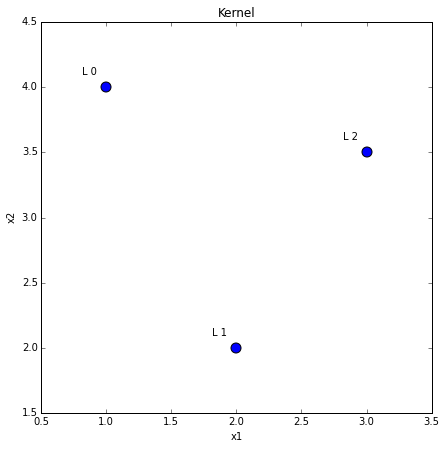

In [4]:
fig = plt.figure(figsize = (7, 7))
ax = plt.subplot(111)
data = np.zeros((3, 2))
data[:,0] = [1.0, 2.0, 3.0]
data[:,1] = [4.0, 2.0, 3.5]

ax.scatter(data[:,0], data[:,1], s=100)
ax.set_title("Kernel")
ax.set_xlabel('x1')
ax.set_ylabel('x2')

labels = ["L {:d}".format(i) for i in xrange(3)]

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.0))

###Manually select 3 points, referred to as "landmarks"

###Define new features as follows:

###Given $x$:

###$f_{1} =  \text{ similarity}(x, L^{1}) = exp \left( \frac{-||x - L^{1}||^{2}}{2\sigma^{2}} \right) = exp \left( \frac{-\sum_{j=1}^{N}(x_{j}-L_{j}^{1})^{2}}{2\sigma^{2}} \right)$

###where $||x - L||$ is the euclidean distance between the point $x$ and the landmark point $L$

###and likewise:

###$f_{2} =  \text{ similarity}(x, L^{2}) = exp \left( \frac{-||x - L^{2}||^{2}}{2\sigma^{2}} \right)$

###$f_{3} =  \text{ similarity}(x, L^{3}) = exp \left( \frac{-||x - L^{3}||^{2}}{2\sigma^{2}} \right)$

###The 'similiarity' is referred to as a Kernel Function, which is also denoted $k(x, L^{1})$
###This particular kernel is a Guassian Kernel

###if $x \approx L^{1}$ then:

###$f_{1} \approx exp \left( \frac{-0^{2}}{2\sigma^{2}} \right) \approx 1.0$

###if $x$ is far from $L^{1}$ then:

###$f_{1} \approx exp \left( \frac{-(\text{large number})^{2}}{2\sigma^{2}} \right) \approx 0.0$


###So given a training example $x$ we can determine $3$ new features $f_{1}, f_{2}, \text{ and } f_{3}$

In [5]:
def norm_D(x, the_mean, the_sigma):
    '''This function uses the linear algebra library to calculate the 2 D normal distribution, given a point in 2 D, vector of means and a covariance matrix
    x - the point in 2D
    the_mean - the vector of means
    the_sigma - the covariance matrix
    '''
    
    temp1 = (1.0/np.power(2.0 * np.pi, 2.0/2.)) * (1.0/np.sqrt(np.linalg.det(the_sigma)))
    x_m = np.matrix(x)    
    the_mean_m = np.matrix(the_mean)    
    temp3 = x_m - the_mean_m
    temp4 = np.dot(temp3, np.linalg.inv(the_sigma))
    temp5 = np.dot(temp4, np.transpose(temp3))
    temp6 = -0.5 * np.matrix.item(temp5)
    return temp1 * np.exp(temp6)

#####Observe the features $f$, given 3 points close to a landmark

for xa = 5.0, 3.0, f = 0.00867
for xb = 7.0, 5.0, f = 0.00261
for xc = 2.0, 5.0, f = 0.03183


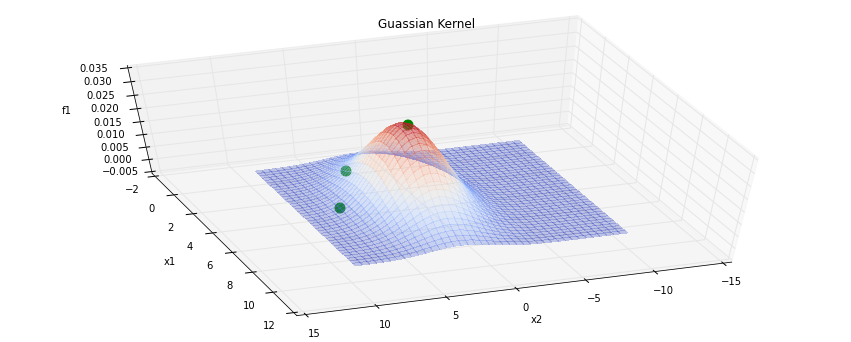

In [7]:
#specify the variance in the covariance matrix as s
#co-variance matrix is diagonal 

s = 5.0
the_sigma = np.zeros((2, 2))
the_sigma[0][0] = s
the_sigma[1][1] = s

#here is the landmark point at (2, 5)
the_mean = np.array([2.0, 5.0])

#let's make the plot 3D
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(3, 1, 1, projection='3d')

X = np.arange(-10, 10, 0.5)
Y = np.arange(0, 10, 0.25)
X, Y = np.meshgrid(X, Y)

A = len(X)
Z=[]
for i in range(A):
    for j in range(A):
        #plotting a 2 D Gaussian, using the norm_D function
        Z.append(norm_D([X[i][j], Y[i][j]], the_mean, the_sigma))
Z = np.array(Z)
Z = Z.reshape(A, A)


#Alter the view onto the graph here
ax.elev=55.0
ax.azim=70.0

ax.set_title("Guassian Kernel")
ax.set_xlabel("x2")
ax.set_ylabel("x1")
ax.set_zlabel("f1")

#This is the 2 D surface plot
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.3)

#here are values of x, let's see what new features they generate, using the Gaussian kernel
xa = [5.0, 3.0]
xb = [7.0, 5.0]
xc = [2.0, 5.0]

#plot the 3 points
ax.scatter(xa[0], xa[1], norm_D(xa, the_mean, the_sigma),  s=100, color="green")
ax.scatter(xb[0], xb[1], norm_D(xb, the_mean, the_sigma),  s=100, color="green")
ax.scatter(xc[0], xc[1], norm_D(xc, the_mean, the_sigma),  s=100, color="green")

#the new feature f, depends on the closeness or similarity of x to the center of the kernel
#change the variance (s above) and see the effects it has on f
print "for xa = {:3.1f}, {:3.1f}, f = {:0.5f}".format(xa[0], xa[1], norm_D(xa, the_mean, the_sigma))
print "for xb = {:3.1f}, {:3.1f}, f = {:0.5f}".format(xb[0], xb[1], norm_D(xb, the_mean, the_sigma))
print "for xc = {:3.1f}, {:3.1f}, f = {:0.5f}".format(xc[0], xc[1], norm_D(xc, the_mean, the_sigma))

###So using a Guassian centered at landmarks we can extract new features $f$ for $x$

###Now note the effect of $\sigma^{2}$ in the above example

###$\sigma^{2}$ is defining our volume

##Now consider 2 points $x_{A}$, and $x_{B}$

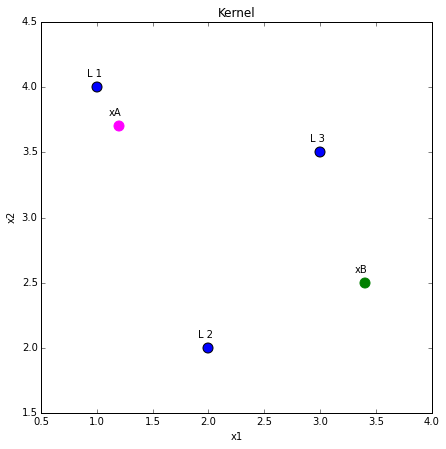

In [103]:
fig = plt.figure(figsize = (7, 7))
ax = plt.subplot(111)
data = np.zeros((3, 2))
data[:,0] = [1.0, 2.0, 3.0]
data[:,1] = [4.0, 2.0, 3.5]

ax.scatter(data[:,0], data[:,1], s=100)
ax.set_title("Kernel")
ax.set_xlabel('x1')
ax.set_ylabel('x2')

labels = ["L {:d}".format(i) for i in xrange(1, 4)]

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points')
    
ax.scatter([1.2], [3.7], color='magenta', s=100)
ax.scatter([3.4], [2.5], color='green', s=100)

ax.annotate("xA", xy = (1.2, 3.7), xytext = (-10, 10), textcoords = 'offset points')
ax.annotate("xB", xy = (3.4, 2.5), xytext = (-10, 10), textcoords = 'offset points')

###for a new point $xA$ we calculate $f_{1}, f_{2}, \text{ and } f_{3}$

###$f_{1} \approx 1$
###$f_{2} \approx 0$
###$f_{3} \approx 0$

###Suppose I know the values for $\theta$, such that $\theta_{0} = -0.5, \theta_{1}=1.0, \theta_{2}=1.0, \text{ and } \theta_{3} = 0.0$

###Therefore, $\theta_{0} + \theta_{1}f_{1} + \theta_{2}f_{2} + \theta_{3}f_{3} = 0.5$
###$0.5 \geq 0$ and so we predict $1$

---
###and
---

###for a new point $xB$ we calculate $f_{1}, f_{2}, \text{ and } f_{3}$

###$f_{1} \approx 0$
###$f_{2} \approx 0$
###$f_{3} \approx 0$

###Suppose I know the values for $\theta$, such that $\theta_{0} = -0.5, \theta_{1}=1.0, \theta_{2}=1.0, \text{ and } \theta_{3} = 0.0$

###Therefore, $\theta_{0} + \theta_{1}f_{1} + \theta_{2}f_{2} + \theta_{3}f_{3} = -0.5$
###$-0.5 \lt 0$ and so we predict $0$

###This allows for the calculation of very complex non-linear decision boundaries

###For the example above it would create a decision boundary around the $L_{1}$ and $L_{2}$ landmark points

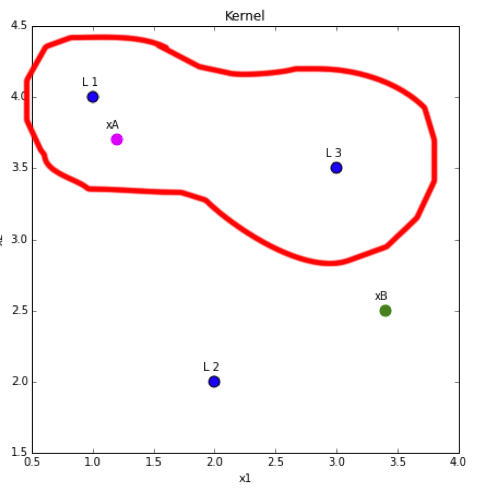

In [3]:
from IPython.display import Image
Image(filename='./Assets/svmA.png') 

###How do we choose the landmarks - both number and position

###Use the training examples!! - as the landmarks

###So if there are $m$ training examples then there will be $m$ landmarks

###Given a new point $x$, you will compare it with each of the landmarks, resulting in a feature vector of size $m$

###$f_{1} = similarity(x, L^{1})$
###$f_{2} = similarity(x, L^{2})$
###...
###$f_{m} = similarity(x, L^{m})$

###So the feature vector becomes: $f_{1}, f_{2}, ..., f_{m}$

###and you predict $y=1$ if $\theta f \geq 0$

###$$h(x) = \theta_{0} + \theta_{1}f_{1} + \theta_{2}f_{2} + \theta_{3}f_{3} ... + \theta_{m}f_{m}$$

###This new hypothesis then gets put into the SVM cost function, to determine $\theta$

###You can use the idea of kernels fo logistic regression!!, but SVMs have computational optimizations that allow the training to be performed quickly. 

###Using kernels in logistic regression tends to be slow, because you cannot apply the same computational optimisations.

---
Support Vector Machines
=====
***

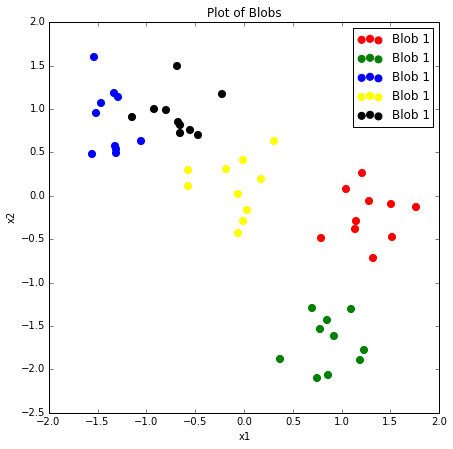

In [79]:
#number of training examples
m = 50

#number of features
N = 2

#number of distinct clusters or groupings or 'blobs'
num_blobs = 5

#using sklearn's 'make_blobs' functionality to make some clusters of data
#blobs also returns an array, y, which contains the identity of the blob each pair of points belongs to
X, y = make_blobs(n_samples = m, n_features = N, centers=num_blobs, cluster_std=1.5, random_state=6)

#you MUST scale your data
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True).fit(X)
X_scaled = scaler.transform(X)

color_list = ['red', 'green', 'blue', 'yellow', 'black', 'orange', 'magenta', 'cyan']

#Plot the blobs and color them for each blob
fig = plt.figure(figsize = (7,7))
ax = plt.subplot(111)
for i in xrange(num_blobs):
    ax.scatter(X_scaled[y == i,0], X_scaled[y == i,1], color=color_list[i], s=50, label='Blob 1')
ax.set_title("Plot of Blobs")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend(loc='best')

#####Consider the decision boundary with a linear kernel and an rbf (Gaussian) kernel

In [84]:
#Fit a basic logistic regression model
clfL = SVC(C=1.0, kernel='linear', cache_size = 800, random_state = 101) 

clfL.fit(X_scaled, y)

#A confusion matrix indicates the results of classification
#pd.crosstab returns a DataFrame
cm = pd.crosstab(y, clfL.predict(X_scaled), rownames=["Actual"], colnames=["Predicted"])
cm

Predicted,0,1,2,3,4
Actual,,,,,
0,10,0,0,0,0
1,0,10,0,0,0
2,0,0,10,0,0
3,0,0,0,10,0
4,0,0,1,0,9


In [88]:
clfRBF = SVC(C=1000.0, kernel='rbf', cache_size = 800, random_state = 101) 
clfRBF.fit(X_scaled, y)

cm = pd.crosstab(y, clfRBF.predict(X_scaled), rownames=["Actual"], colnames=["Predicted"])
cm

Predicted,0,1,2,3,4
Actual,,,,,
0,10,0,0,0,0
1,0,10,0,0,0
2,0,0,10,0,0
3,0,0,0,10,0
4,0,0,0,0,10


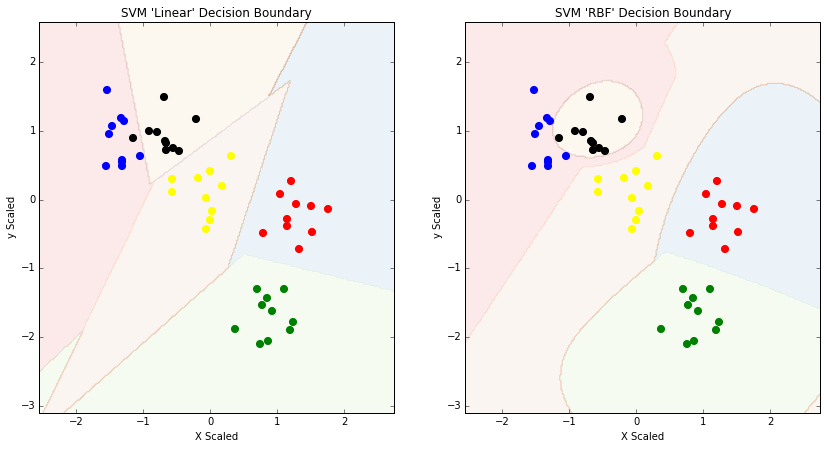

In [89]:
fig = plt.figure(figsize = (14, 7))
ax = plt.subplot(121)

#find the limits required for the plot
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1

#step size for the mesh
step_size = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))

#predict over the mesh
Z = clfL.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.1)

#re-plot the points
for i in xrange(num_blobs):
    ax.scatter(X_scaled[y == i,0], X_scaled[y == i,1], color=color_list[i], s=50)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title("SVM 'Linear' Decision Boundary")
ax.set_xlabel("X Scaled")
ax.set_ylabel("y Scaled")


ax = plt.subplot(122)
#predict over the mesh
Z = clfRBF.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.1)

#re-plot the points
for i in xrange(num_blobs):
    ax.scatter(X_scaled[y == i,0], X_scaled[y == i,1], color=color_list[i], s=50)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title("SVM 'RBF' Decision Boundary")
ax.set_xlabel("X Scaled")
ax.set_ylabel("y Scaled")

---
#Compared with Logistic Regresssion
---

In [101]:
#Fit a basic logistic regression model
clfLogR = LogisticRegression(C=10000) 
clfLogR.fit(X_scaled, y)

cm = pd.crosstab(y, clfLogR.predict(X_scaled), rownames=["Actual"], colnames=["Predicted"])
cm

Predicted,0,1,2,3,4
Actual,,,,,
0,10,0,0,0,0
1,0,10,0,0,0
2,0,0,10,0,0
3,0,0,0,9,1
4,0,0,0,0,10


In [107]:
#Fit a logistic regression model with polynomial features
clfLogRNL = make_pipeline(PolynomialFeatures(2), LogisticRegression(C=1000))
clfLogRNL.fit(X_scaled, y)

cm = pd.crosstab(y, clfLogRNL.predict(X_scaled),rownames=["Actual"], colnames=["Predicted"])
cm

Predicted,0,1,2,3,4
Actual,,,,,
0,10,0,0,0,0
1,0,10,0,0,0
2,0,0,10,0,0
3,0,0,0,10,0
4,0,0,0,0,10


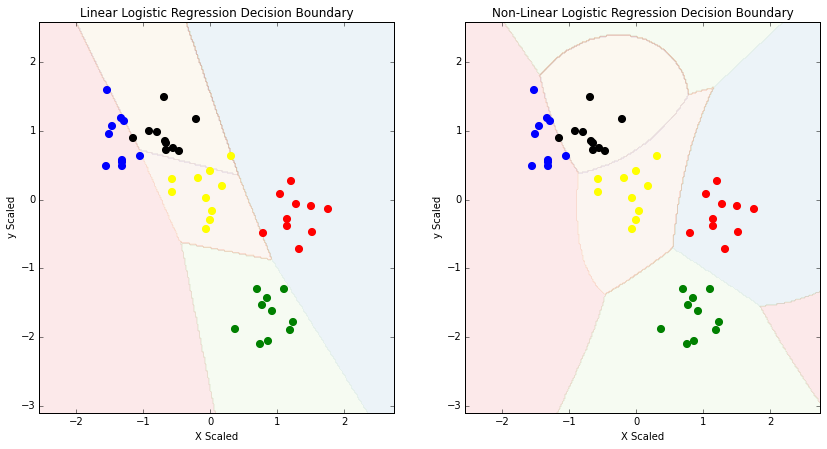

In [108]:
fig = plt.figure(figsize = (14, 7))
ax = plt.subplot(121)

#find the limits required for the plot
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1

#step size for the mesh
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#predict over the mesh
Z = clfLogR.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.1)

#re-plot the points
for i in xrange(num_blobs):
    ax.scatter(X_scaled[y == i,0], X_scaled[y == i,1], color=color_list[i], s=50)


ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title("Linear Logistic Regression Decision Boundary")
ax.set_xlabel("X Scaled")
ax.set_ylabel("y Scaled")


ax = plt.subplot(122)
#predict over the mesh
Z = clfLogRNL.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.1)

#re-plot the points
for i in xrange(num_blobs):
    ax.scatter(X_scaled[y == i,0], X_scaled[y == i,1], color=color_list[i], s=50)


ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title("Non-Linear Logistic Regression Decision Boundary")
ax.set_xlabel("X Scaled")
ax.set_ylabel("y Scaled")

#####What np.c_ does

In [124]:
test = np.c_[np.array([[1,2,3]]), 0, 0, np.array([[4,5,6]])]
print test

[[1 2 3 0 0 4 5 6]]
